In [1]:
import numpy as np
import os
import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt

import sys
from pathlib import Path
from scipy.signal import butter, lfilter

import json
import commentjson
import pickle
import scipy.io as sio
from pathlib import Path
import numpy as np

In [2]:
def parse_txt(text_lines):
    time, ch1, ch2 = [], [], []
    for i, line in enumerate(text_lines):
        if i < 6:
            continue
        line = line.split("; ")
        try:
            time.append(float(line[0]))
            ch1.append(float(line[1]))
            ch2.append(float(line[2]))
        except:
            print("End line at {} ".format(i))
            break
    return np.asarray(time), np.asarray(ch1), np.asarray(ch2)

def load_text(path):
    with open(path) as f:
        return [l.replace("\n", "") for l in f.readlines()]

In [3]:
data_path = "../data/det_idxs.npy"
data = np.load(data_path)

In [4]:
data

array([   4025,   27832,   46438,   49915,   53421,   56559,   59370,
         64722,   67251,   72330,   74926,   77469,  173951,  177359,
        180461,  189428,  195440,  198343,  201195,  204119,  207187,
        224614,  243147,  294361,  316204,  330686,  333355,  336182,
        338873,  341480,  350770,  358033,  361470,  364665,  446078,
        452167,  458257,  461248,  463998,  466665,  472048,  474761,
        477391,  482757,  484119,  501132,  519939,  569774,  591331,
        607542,  610500,  613518,  616683,  619993,  627487,  631690,
        640273,  644068,  646995,  731796,  735300,  738901,  745117,
        753828,  756740,  759505,  765266,  766455,  770859,  781172,
        800049,  850022,  874489,  892194,  897680,  900291,  902777,
        910456,  913004,  915625,  918351,  920944, 1018090, 1021056,
       1023776, 1031736, 1036854, 1039434, 1042037, 1047349, 1064479,
       1088407, 1150958, 1158877, 1173718, 1176135, 1178497, 1180862,
       1183426, 1188

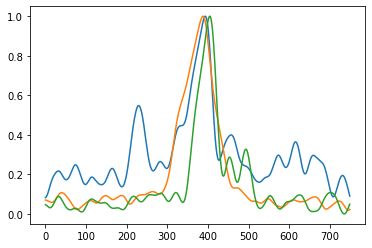

In [5]:
pattern_path = "../asset/patterns/p1.npy"
pattern0 = np.load(pattern_path)

plt.plot(range(len(pattern0)) , pattern0)

pattern_path = "../asset/patterns/p2.npy"
pattern1 = np.load(pattern_path)

plt.plot(range(len(pattern1)) , pattern1)

pattern_path = "../asset/patterns/p3.npy"
pattern2 = np.load(pattern_path)

plt.plot(range(len(pattern2)) , pattern2)

In [6]:
#generate data
data_path = "../data/meas_scope_20210823.txt"
time, raw_data, triangle_waves = parse_txt(load_text(data_path))
root_dir = os.path.split(data_path)[0]

End line at 2537861 


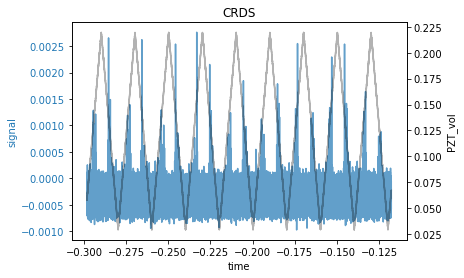

In [7]:
fig, ax1 = plt.subplots()
plt.title('CRDS')
plt.xlabel('time')
ax2 = ax1.twinx()

ax1.set_ylabel('signal', color='tab:blue')
ax1.plot(time,raw_data, color='tab:blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2.set_ylabel('PZT_vol', color='black')
ax2.plot( time, triangle_waves, color='black', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='black')

In [8]:
def cyc_searching (data,window):
    temp_max =0 ;
    i=0
    ind_min= 0;
    ind_max=0;
    A = data[0:window];
    B = data[window+1:2*window+1];
    if((np.max(B)-np.max(A))>0):
        direct ="up";
    else:
        direct = "down"
    collect = []
    while(1):
        A = data[i:i+window];
        B = data[i+window+1:i+2*window+1];
        if ((np.max(B)-np.max(A)) == 0): i=i+window;
        if(direct == "up"):
            #start collect
            if((np.max(B)-np.max(A))>0):       
                i=i+window;
                if((i+2*window+1)>len(data)): return collect;
            else:            
                ind_max=i+np.argmax(A)
                direct = "down";
                
        if(direct == "down"):        
            if((np.min(A)- np.min(B))>0):
                i=i+window;
                if((i+2*window+1)>len(data)): return  collect;
            else:
                ind_min=i+np.argmin(A)
                collect.append([ind_max,ind_min])
                direct = "up"

In [9]:
window = 4000
ind = cyc_searching(triangle_waves,window)
ind

[[119496, 260101],
 [400687, 541377],
 [681949, 822650],
 [963225, 1103915],
 [1244472, 1385157],
 [1525730, 1666394],
 [1807048, 1947530],
 [2088290, 2228894],
 [2369490, 2510139]]

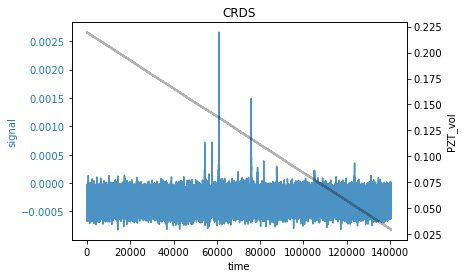

In [10]:
plt_data = raw_data[ind[0][0]:ind[0][1]]
plt_tri = triangle_waves[ind[0][0]:ind[0][1]]
x = range(len(plt_data))
fig, ax1 = plt.subplots()
plt.title('CRDS')
plt.xlabel('time')
ax2 = ax1.twinx()
ax1.set_ylabel('signal', color='tab:blue')

ax1.plot(x,plt_data, color='tab:blue', alpha=0.8)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2.set_ylabel('PZT_vol', color='black')
ax2.plot(x, plt_tri, color='black', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='black')

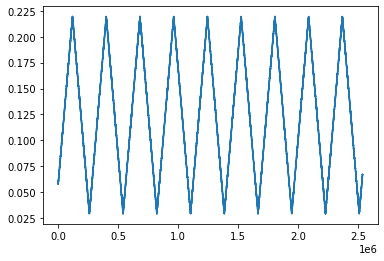

In [11]:
plt.plot(range(len(triangle_waves)) , triangle_waves)

In [12]:
ind

[[119496, 260101],
 [400687, 541377],
 [681949, 822650],
 [963225, 1103915],
 [1244472, 1385157],
 [1525730, 1666394],
 [1807048, 1947530],
 [2088290, 2228894],
 [2369490, 2510139]]

In [13]:
new_time = []
new_filted_src = []
new_triangle_waves = []
new_peak_collect = []
for i in range(len(ind)):
    tmp=[]
    new_time.append(time[ind[i][0] :ind[i][1]])
    new_filted_src.append(raw_data[ind[i][0] :ind[i][1]])
    new_triangle_waves.append(triangle_waves [ind[i][0] :ind[i][1]])
    
    for x in data:
        if((x < ind[i][1]) & (x > ind[i][0] )):
            tmp.append(x)
    new_peak_collect.append(tmp)


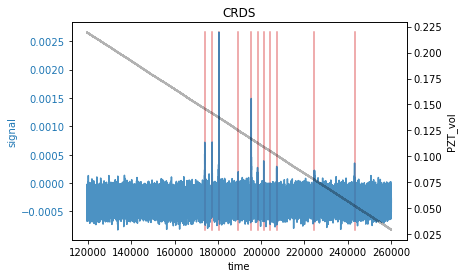

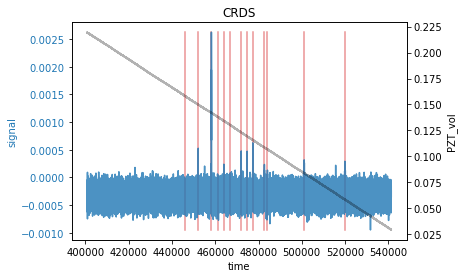

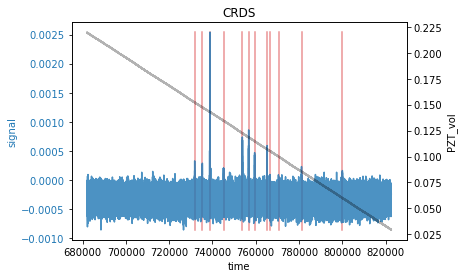

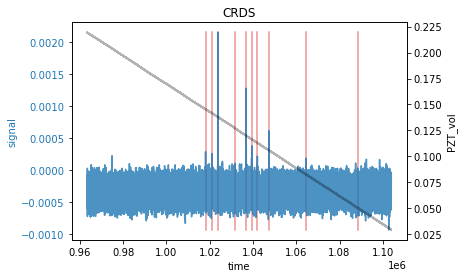

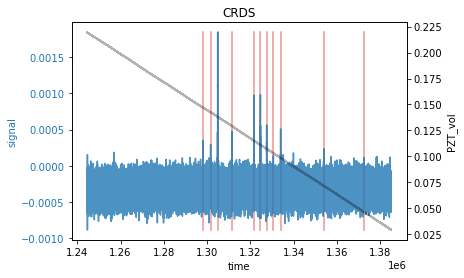

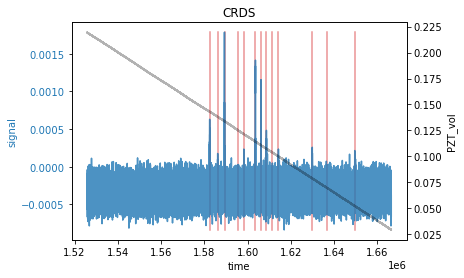

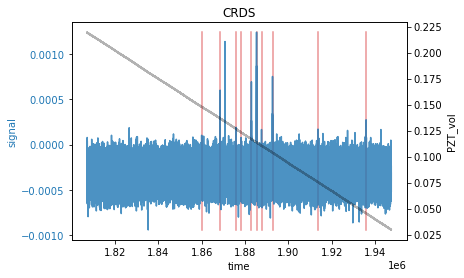

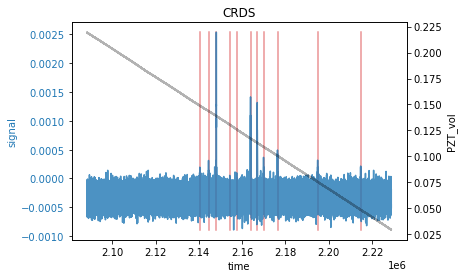

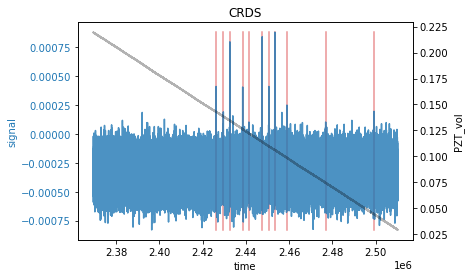

In [14]:
for num in range(len(ind)):
    min_max = [np.min(new_filted_src[num]), np.max(new_filted_src[num])]
    x= np.arange(ind[num][0],ind[num][1],1)
    fig, ax1 = plt.subplots()
    plt.title('CRDS')
    plt.xlabel('time')
    ax2 = ax1.twinx()
    ax1.set_ylabel('signal', color='tab:blue')

    for i in new_peak_collect[num]:
        ax1.plot([i,i],min_max, color='tab:red', alpha=0.5)  

    ax1.plot(x,new_filted_src[num], color='tab:blue', alpha=0.8)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2.set_ylabel('PZT_vol', color='black')
    ax2.plot(x, new_triangle_waves[num], color='black', alpha=0.3)
    ax2.tick_params(axis='y', labelcolor='black')
    plt.show()

In [15]:
delta = []
for i in range(len(new_peak_collect)):
    for j in range(len(new_peak_collect[i])):
        if(j!=0):
            d = new_peak_collect[i][j] - pre_tmp
            delta.append(d)
        pre_tmp = new_peak_collect[i][j]

max= 2700


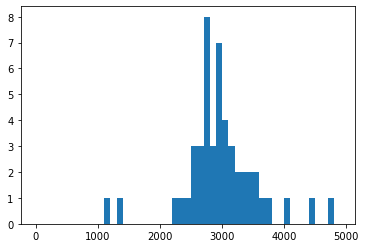

In [17]:
bins = range(0, 5000, 100)
counts, bins = np.histogram(delta,bins)
max_val = bins[np.argmax(counts)]
plt.stairs(counts, bins,fill=True)
print("max=",max_val)


# Sample-1

In [ ]:
num =3
go_start =ind[num][0] + 30000
go_end = ind[num][1] -5000
min_max = [np.min(new_filted_src[num]), np.max(new_filted_src[num])]
x= np.arange(ind[num][0],ind[num][1],1)
i_start = np.where(x==go_start)[0][0]
i_end = np.where(x==go_end)[0][0]

In [ ]:
fig, ax1 = plt.subplots()
plt.title('CRDS')
plt.xlabel('time')
ax2 = ax1.twinx()
ax1.set_ylabel('signal', color='tab:blue')

for i in range(25):
    i_set=i*2750+new_peak_collect[3][0]
    ax1.plot([i_set,i_set],min_max, color='tab:green', alpha=0.9)  
for i in new_peak_collect[num]:
    ax1.plot([i,i],min_max, color='tab:red', alpha=0.7)  
    
ax1.plot(x[i_start:i_end],new_filted_src[num][i_start:i_end], color='tab:blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2.set_ylabel('PZT_vol', color='black')
ax2.plot(x[i_start:i_end], new_triangle_waves[num][i_start:i_end], color='black', alpha=0.1)
ax2.tick_params(axis='y', labelcolor='black')

In [ ]:
# trim the package due to evey package has different length to plot
def do_trim_package(ds):
    min_l=0xffffffff
    for num in range(len(ds)):
        l = len(ds[num][1])
        print(l)
        if(min_l>l): 
            min_l = l
    print("min_l:" , min_l)    
    if(min_l==0xffffffff):
        print("trim_error")     
    else:
        for num in range(len(ds)):
            ds[num][1] = ds[num][1][0:min_l]
            ds[num][2] = ds[num][2][0:min_l]
    
# rearrange all data and det_sig with 0 - lens
# for seeing every scanning as a single experiment
# the det_sig marked as 1 ; elsewhere as 0; 
def package_generator(pzt_ind, raw_data, det_peaks):
    ds = []
    for num in range(len(pzt_ind)):

        tmp_data=[]        
        first_ind = pzt_ind[num][0]
        final_ind = pzt_ind[num][1]
        tmp_data = raw_data[pzt_ind[num][0]:pzt_ind[num][1]]
        
        tmp_peaks=np.zeros(len(tmp_data))
        for peak in det_peaks:
            if ((peak>first_ind) & (peak < final_ind)):
                tmp_peaks[peak-first_ind] = 1 #marked
        ds.append([num, tmp_data, tmp_peaks])
    return ds

def find_peak(ds,num,pt):
    count =0;
    for i in range(len(ds[num][2])):
        if(ds[num][2][i] == 1):            
            if(count == pt):
                return i
            else:
                count = count + 1

# Test

In [ ]:
ds = package_generator(ind,raw_data,data)
do_trim_package(ds)

In [ ]:
num =2 
data_len = len(ds[num][1])
x= np.arange(0, data_len,1)
y1 = ds[num][1]
y2 = ds[num][2]

fig, ax1 = plt.subplots()
plt.title('CRDS')
plt.xlabel('time')
ax2 = ax1.twinx()
ax1.set_ylabel('signal', color='tab:blue')

ax1.plot(x,y1, color='tab:blue', alpha=0.7) 
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2.set_ylabel('det_sig', color='black')
ax2.plot(x, y2, color='black', alpha=0.1)
ax2.tick_params(axis='y', labelcolor='black')

# Analysis relation between localizations of all the det_sig 

In [ ]:
init_pt = find_peak(ds,0,1)
print(init_pt)

In [ ]:
data_len = len(ds[num][1])
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
init_pt = find_peak(ds,1,0)

for i in range(30):
    i_set=i*3000+init_pt
    plt.plot([i_set,i_set],[0,len(ds)], color='tab:green', alpha=0.2) 
for num in range(len(ds)):
    y = ds[num][2] *(num+1)
    plt.plot(x,y, 'o')   
    

In [ ]:
#pzt 的不確定性 => 多了一個變數

def do_align_package(ds):
    min_p=0xffffffff    
    for num in range(len(ds)):
        pt=len(ds[num][2])-1
        p = ds[num][2][pt]
        print(p)
        if(min_p>p): 
            min_p = p
        print(min_p)

In [ ]:
def add_active_region(ds_t):
    active_region = np.zeros(len(ds_t[2]))
    
    


# T = t0 

In [ ]:
# first data input
ds_t0= ds[0][2]

In [ ]:
#設定: 預判的peaks
#假設我已知大約的 comb spacing 例如: 3000
def init_virtual_peaks(ds_t0, combspac):
    #初始化
    vs_t0=np.zeros(len(ds_t0))
    pt = _find_peaks(ds_t0,0)
    while(pt<len(vs_t0)):       
        vs_t0[pt] = 1
        pt =  pt + combspac
    return vs_t0

def update_virtual_peaks(ds_t, vs_t, width,combspac):
       
    vs_tmp = init_virtual_peaks(ds_t,3000)
    p1 = _find_peaks(vs_t ,0)
    p2 = _find_peaks(vs_tmp ,0)
    edge = len(vs_tmp)- 2 * width
    
    if(p2>p1): 
        pt = p1
        print("case1")
        
        if (pt - width <0):
            print("update error: pt - width <0 ")
            return -1 
        count=0
        
        while(pt!=-1):
            for w in range(width):
                if(vs_tmp[pt - width + 2 * w] == 1):
                        #reset
                        vs_t[pt] = 0
                        #update: (pt + (pt - width + 2*w))/2
                        vs_t[(pt- round(width/2) + w)] = 1            

            count = count + 1;
            pt = _find_peaks(vs_t,count)
            
        return vs_t
    else:
        pt = p2
        print("case2")
    
        if (pt - width <0):
            print("update error: pt - width <0 ")
            return -1 

        while(pt < edge):
            for w in range(width):
                if(vs_t[pt - width + 2 * w] == 1):
                        #reset
                        vs_tmp[pt] = 0
                        #update: (pt + (pt - width + 2*w))/2
                        vs_tmp[pt- round(width/2) + w] = 1            


            pt = pt + combspac
        return vs_tmp


    
    
def _count_peaks(vs_t):
    count =0
    for i in range(len(vs_t)):
        if(vs_t[i]):
            count = count+1
    if(count==0): print("warning: no peak")
    return count

def _find_peaks(vs_t,pt):
    count =0;
    for i in range(len(vs_t)):
        if(vs_t[i] == 1):            
            if(count == pt):
                return i
            else:                
                count = count + 1
    return -1

In [ ]:
vs_t0 = init_virtual_peaks(ds_t0,2750)

In [ ]:
print(_count_peaks(vs_t0))

# T = t1

In [ ]:
ds_t1 = ds[1][2]


In [ ]:
vs_t1 = update_virtual_peaks(ds_t1,vs_t0,300,3000)

In [ ]:
data_len = len(ds[num][1])
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
init_pt = find_peak(ds,1,0)
plt.axhline(y=1, color='r', linestyle='-')
plt.plot(x,vs_t1*8,'--')
for num in range(len(ds)):
    y = ds[num][2] *(num+1)
    plt.plot(x,y, 'o')   

# T=t2

In [ ]:
ds_t2 = ds[1][2]
vs_t2 = update_virtual_peaks(ds_t2,vs_t0,1000,3000)

In [ ]:
data_len = len(ds[1][1])
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
init_pt = find_peak(ds,1,0)
plt.axhline(y=2, color='r', linestyle='-')
plt.plot(x,vs_t2*8,'--')
for num in range(len(ds)):
    y = ds[num][2] *(num+1)
    plt.plot(x,y, 'o')   

# T=t3

In [ ]:
ds_t3 = ds[3][2]
vs_t3 = update_virtual_peaks(ds_t3,vs_t2,1000,3000)
data_len = len(ds[num][1])
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
init_pt = find_peak(ds,1,0)
plt.axhline(y=4, color='r', linestyle='-')
plt.plot(x,vs_t3*8,'--')
for num in range(len(test)):
    y = ds[num][2] *(num+1)
    plt.plot(x,y, 'o')   

# T=t4

In [ ]:
n=4
ds_t4 = ds[n][2]
vs_t4 = update_virtual_peaks(ds_t4,vs_t3,1000,3000)
data_len = len(ds[n][1])
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
init_pt = find_peak(ds,1,0)
plt.axhline(y=(n+1), color='r', linestyle='-')
plt.plot(x,vs_t3*8,'--')
for num in range(len(test)):
    y = ds[num][2] *(num+1)
    plt.plot(x,y, 'o')   

In [ ]:
n=5
ds_t5 = ds[n][2]
vs_t5 = update_virtual_peaks(ds_t5,vs_t4,1000,3000)
data_len = len(ds[n][1])
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
init_pt = find_peak(ds,1,0)
plt.axhline(y=(n+1), color='r', linestyle='-')
plt.plot(x,vs_t3*8,alpha=0.5)
for num in range(len(test)):
    y = ds[num][2] *(num+1)
    plt.plot(x,y, 'o')   

In [ ]:
co = _count_peaks(vs_t5)

In [ ]:
co